<h1><center>Analyzing Amazon product reviews with Vader</center></h1>
 H.M

#### Import the libraries 

In [ ]:
import pandas as pd 
import seaborn as sb 
import numpy as np 
import nltk 
import spacy 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [5]:
# get the reviews 
amazon=pd.read_csv('amazonreviews.tsv',sep='\t')

In [11]:
#check the head 
amazon.head()

,review,label
0,Stuning even for the non-gamer: This sound tra...,pos
1,The best soundtrack ever to anything.: I'm rea...,pos
2,Amazing!: This soundtrack is my favorite music...,pos
3,Excellent Soundtrack: I truly like this soundt...,pos
4,"Remember, Pull Your Jaw Off The Floor After He...",pos


#### Some EDA 

In [12]:
#rearange the columns names 
# Or amazon=amazon[['review','label']]
amazon = amazon.reindex(columns=['review','label'])


In [13]:
amazon.head()

,review,label
0,Stuning even for the non-gamer: This sound tra...,pos
1,The best soundtrack ever to anything.: I'm rea...,pos
2,Amazing!: This soundtrack is my favorite music...,pos
3,Excellent Soundtrack: I truly like this soundt...,pos
4,"Remember, Pull Your Jaw Off The Floor After He...",pos


In [14]:
#get some infos about the df 
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  10000 non-null  object
 1   label   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [15]:
amazon.shape


(10000, 2)

In [17]:
# group by label 
amazon.groupby('label').size()

label
neg    5097
pos    4903
dtype: int64

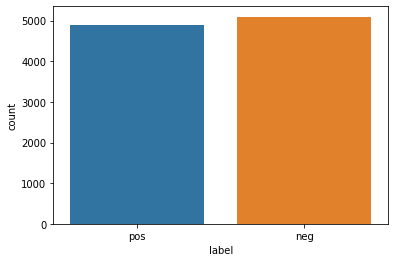

In [19]:
#plot this 
sb.countplot(data=amazon,x='label')

In [24]:
# show if there is null rows and drop them 
amazon.isnull().sum()
# No Null values 

review    0
label     0
dtype: int64

#### Put some sentiment scores to the reviews in the DF 

In [22]:
# add another features to  the df 
sid=SentimentIntensityAnalyzer()
scores = amazon['review'].apply(lambda review: sid.polarity_scores(review))


[{'neg': 0.088, 'neu': 0.669, 'pos': 0.243, 'compound': 0.9454}, {'neg': 0.018, 'neu': 0.837, 'pos': 0.145, 'compound': 0.8957}, {'neg': 0.04, 'neu': 0.692, 'pos': 0.268, 'compound': 0.9858}, {'neg': 0.09, 'neu': 0.615, 'pos': 0.295, 'compound': 0.9814}, {'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'compound': 0.9781}]


In [23]:
#show the first dictionnary 
print(list(scores)[0])

{'neg': 0.088, 'neu': 0.669, 'pos': 0.243, 'compound': 0.9454}


#### Separate them 

In [25]:
amazon['positive'] = scores.apply(lambda score_dict: score_dict['pos'])
amazon['negative'] = scores.apply(lambda score_dict: score_dict['neg'])
amazon['neutral'] = scores.apply(lambda score_dict: score_dict['neu'])
amazon['compound']  =scores.apply(lambda score_dict: score_dict['compound'])

In [26]:
amazon.head()

,review,label,positive,negative,neutral,compound
0,Stuning even for the non-gamer: This sound tra...,pos,0.243,0.088,0.669,0.9454
1,The best soundtrack ever to anything.: I'm rea...,pos,0.145,0.018,0.837,0.8957
2,Amazing!: This soundtrack is my favorite music...,pos,0.268,0.040,0.692,0.9858
3,Excellent Soundtrack: I truly like this soundt...,pos,0.295,0.090,0.615,0.9814
4,"Remember, Pull Your Jaw Off The Floor After He...",pos,0.254,0.000,0.746,0.9781


#### Let's predict the review's label using only compound score in classification 

In [36]:
#now let's predict the polarity of the reviews 
# let's define a function that labelize the reviw from its compund score 
def review_rating(review):
    
    scores = sid.polarity_scores(review)
    if scores['compound']>0:
        return 'pos'
    else:
        return 'neg'

In [37]:
#now let's apply it the df reviews
amazon['predicted_label'] =amazon['review'].apply(review_rating)

In [38]:
#show the head of the new df
amazon.head()

,review,label,positive,negative,neutral,compound,predicted_label
0,Stuning even for the non-gamer: This sound tra...,pos,0.243,0.088,0.669,0.9454,pos
1,The best soundtrack ever to anything.: I'm rea...,pos,0.145,0.018,0.837,0.8957,pos
2,Amazing!: This soundtrack is my favorite music...,pos,0.268,0.040,0.692,0.9858,pos
3,Excellent Soundtrack: I truly like this soundt...,pos,0.295,0.090,0.615,0.9814,pos
4,"Remember, Pull Your Jaw Off The Floor After He...",pos,0.254,0.000,0.746,0.9781,pos


In [39]:
#let's show informations about the predicted label 
amazon['predicted_label'].value_counts()

pos    6801
neg    3199
Name: predicted_label, dtype: int64

#### Now, let's evaluate the Results 

In [40]:
# now let's evaluate our results 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
label=amazon['label']
predicted=amazon['predicted_label']

print('Confusion Matrix :',confusion_matrix(label, predicted))
print('\n')
print('Report :',classification_report(label,predicted))
print('\n')
print('accuracy score is :',accuracy_score(label,predicted))

Confusion Matrix : [[2709 2388]
 [ 490 4413]]


Report :               precision    recall  f1-score   support

         neg       0.85      0.53      0.65      5097
         pos       0.65      0.90      0.75      4903

    accuracy                           0.71     10000
   macro avg       0.75      0.72      0.70     10000
weighted avg       0.75      0.71      0.70     10000



accuracy score is : 0.7122


#### Not that bad if w're taking in place the predictions didn't come by ML model 